Unsupervised Learning: K Means Clustering

The aim of this assignment is to classify documents in the three datasets (Enron emails, NIPS full papers & KOS Blog Entries) using k-means clustering & determine an optimal k is each data set.

A similarity measure named Jaccard Index or Jaccard Similarity Coefficient is used to measure the similairty between 2 documents. 
The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:
$J = \dfrac{(A\cap B)}{(A\cup B)}$

The Jaccard coefficient for any two sets is within the range [0, 1]. A higher score indicates a large number of common items in comparison with the total count of elements in sets. Accordingly, high scores for the Jaccard coefficient signify a high degree of similarity. 

Methodology:

For KOS Blog Entries & NIPS datasets, the entire docword.text dataset has been used, for Enron emails dataset as the data is huge, Simple Random Sampling has been used & 4000 random documents have been selected. Since the information about the various document types is unknown, stratified sampling is not used. SRS ensures proper representation of the dataset.

Each of the datasets are converted into sparse matrices, each row is a data point & each column in , A[i][j] is 0/1 based on whether ith document has the jth word from the vocabulary of a dataset.
Using this matrix as input, a modified K-means has been applied to obtain clusters.

Details of Class 'Jaccard_K_Means()':
1. We initalize k random data points/documents as centroids using *initialise_centroids* function (similar to the approach followed by sklearn.KMeans)
2. The Jaccard Distance of each document from each centroid is calculated using *get_j_dist* function for k centroids k*(D), instead of calculating Jaccard distance of each document with all other (D* D compuatations).
3. Each document is then assigned to a cluster which has minimum Jaccard Distance from it's centroid using *assign_to_clusters* function.
4. Now based on the clusters formed, we find the new centroid by finding the Eucliedean  mean of all data points within a cluster using *centroid_update* function
5. The new centroid obtained is converted into a binary array using a threshold value which optimizes the inertia for a particular value of k in k-clusters using *get_new_cent* function.
5. Now all data points are reassigned to various clusters based on these updated centroids. These iterations continue until either the number of iterations cross max_iter or relative distance between the previous & current centroid for the given cluster is below the tolerance (tol). 
6. Using these clusters, Inertia is calculated for all data points, where Inertia is the sum of squared distances of documents to their closest cluster centroid.
7. This measure of Inertia is calculated for 10 values of k & plotted. The optimal k is noted at the elbow of the graph. 


Results:
1. For KOS Blog Entries the graph is as follows:

Looking at the graphs, k = 3 gives the ideal clusters which minimizes the inertia.

2. For NIPS full papers the graph is as follows:

Looking at the graphs, k = 8 gives the ideal clusters which minimizes the inertia.

3. For Enron Emails the graph is as follows:

Looking at the graphs, k = 7 gives the ideal clusters which minimizes the inertia.

In [1]:
import os
import random
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist
from sklearn.decomposition import KernelPCA #1
from mpl_toolkits.mplot3d import Axes3D #4, 20, 37
from sklearn.decomposition import PCA #17, 33
from mpl_toolkits.mplot3d import Axes3D #20
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

%matplotlib inline
seed = random.seed(52)

In [44]:
datafiles = ['docword.enron.txt', 'docword.nips.txt', 'docword.kos.txt'] 
dfs = ["doc_enron_df","doc_nips_df", "doc_kos_df"]
data={}
j=0

for i in datafiles:
    data[dfs[j]] = pd.read_csv(i, skiprows =3, sep = " ", header = None)
    data[dfs[j]].columns = ['docID', 'wordID', 'freq']
    j +=1
    
enron_df = data["doc_enron_df"]
nips_df = data["doc_nips_df"]
kos_df = data["doc_kos_df"]


In [45]:
# Making Matrix for all documents

kos_docs = 3430
kos_words = 6906
 
nips_docs = 1500
nips_words = 12419

enron_docs = 39861
enron_words = 28102

kos = np.zeros(shape=(kos_docs,kos_words))
for i, row in kos_df.iterrows():
    kos[row['docID']-1,row['wordID']-1] = 1

nips = np.zeros(shape=(nips_docs,nips_words))
for i, row in nips_df.iterrows():
    nips[row['docID']-1,row['wordID']-1] = 1


In [46]:
random.seed(54)
state = random.getstate()
random.setstate(state)
docs = random.choices(range(39861), k = 4000)
docs.sort()
enron_sample_mat = np.zeros(shape = (4000, enron_words), dtype = int)
j=0
for i in docs:
    temp = enron_df[enron_df["docID"] == i]
    for k, row in temp.iterrows():
        enron_sample_mat[j,row['wordID']-1]=1
    j+=1


In [47]:
# Defining function to get jaccard distance between the centroid and all points

def get_j_dist(mat1, mat2):
    j_dist_c = []
    for i in range(mat1.shape[0]):
        a = mat1[i:i+1,:]
        b = mat2
        temp_mat = np.concatenate((a,b),axis=0)
        jdist = pairwise_distances(temp_mat, metric='jaccard')[0][1]
        j_dist_c.append(jdist)

    return j_dist_c

# Defining KMeans using Jaccard class

class Jaccard_K_Means():
    def __init__(self, mat, num_c, n_init, max_iter, tol, thres, random_state = seed):
        self.mat = mat
        self.num_c = num_c
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.thres = thres
        self.cnt_conv = 0
        self.random_seed = random_state

        for i in range(self.n_init):
            clus_cent = self.initialise_centroids()

            iter = 0
            flag = 0
            iner_list = []
            clus_cent_list = []
            clus_assign_list = []
            while iter <= self.max_iter:
                inertia, new_cent, dist_prv, clus_assign = self.centroid_update(clus_cent)
                iter += 1
                clus_cent = new_cent
                if dist_prv < self.tol:
                    iner_list.append(inertia)
                    clus_cent_list.append(new_cent)
                    clus_assign_list.append(clus_assign)
                    flag = 1
                    self.cnt_conv += 1
                    break

            if flag == 0:
                iner_list.append(inertia)
                clus_cent_list.append(new_cent)
                clus_assign_list.append(clus_assign)
        
        for i in range(self.n_init):
            min_iner = min(iner_list)
            min_iner_ind = iner_list.index(min_iner)
            self.inertia = iner_list[min_iner_ind]
            self.clus_cent = clus_cent_list[min_iner_ind]
            self.clus_assign = clus_assign_list[min_iner_ind]

    def initialise_centroids(self):
        random.seed(self.random_seed)
        cen = random.sample(list(range(self.mat.shape[0])),self.num_c)
        init_cent = np.zeros((len(cen), self.mat.shape[1]))
        for i in range(len(cen)):
            init_cent[i,:] = self.mat[cen[i],:]

        return init_cent

    def centroid_update(self, clus_cent):
        cent_n = clus_cent.shape[0]
        jd_cen = np.zeros((cent_n, self.mat.shape[0]))
        temp_jd = []
        for i in range(cent_n):
            temp_jd = get_j_dist(self.mat, clus_cent[i:i+1,:])
            jd_cen[i,:] = temp_jd

        clus_assign = self.assign_to_clusters(jd_cen)
        inertia = self.get_inertia(clus_assign)
        new_cent = self.get_new_cent(clus_assign, clus_cent)

        dist_prv = 0
        for i in range(cent_n):
            prv_c = clus_cent[i,:]
            new_c = new_cent[i,:]
            dist_prv += np.linalg.norm(prv_c - new_c)**2
        dist_prv = np.sqrt(dist_prv)

        return inertia, new_cent, dist_prv, clus_assign

    def assign_to_clusters(self, jd_cen):
        clus_assign = []
        for i in range(self.mat.shape[0]):
            min_d = min(jd_cen[:,i])
            min_d_index = np.where(jd_cen[:,i] == min_d)[0][0]
            clus_assign.append((i,min_d_index,min_d))

        return clus_assign

    def get_inertia(self, clus_assign):
        inertia = 0
        for i in range(len(clus_assign)):
            inertia += clus_assign[i][2]**2

        return inertia
    
    def get_new_cent(self, clus_assign, clus_cent):
        cent_n = clus_cent.shape[0]
        new_cent = np.zeros(shape=(cent_n, self.mat.shape[1]))
        for i in range(cent_n):
            cnt_clus = 0
            for j in range(len(clus_assign)):
                if clus_assign[j][1] == i:
                    new_cent[i,:] = new_cent[i,:] + self.mat[j,:]
                    cnt_clus += 1
                else:
                    pass
            
            if cnt_clus != 0:
                new_cent[i,:] = new_cent[i,:]*(1/cnt_clus)
            else:
                pass
        
        for i in range(new_cent.shape[0]):
            for j in range(new_cent.shape[1]):
                if new_cent[i,j] < self.thres:
                    new_cent[i,j] = 0
                else:
                    new_cent[i,j] = 1

        return new_cent

In [66]:
%%time
iner = []
k_list = list(range(2,11))
for i in range(2,11):
    k_model = Jaccard_K_Means(kos, num_c=i, n_init=10, max_iter=300, tol=10**-2, thres=0.1)
    iner.append(k_model.inertia)

Wall time: 54min 55s


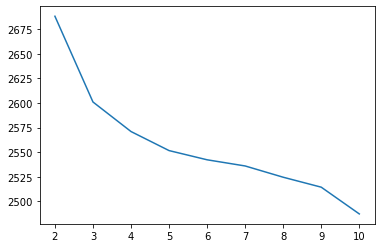

In [67]:
sns.lineplot(x=k_list,y=iner)
plt.show()

In [62]:
%%time
iner = []
k_list = list(range(2,11))
for i in range(2,11):
    k_model = Jaccard_K_Means(nips, num_c=i, n_init=10, max_iter=300, tol=10**-2, thres=0.2)
    iner.append(k_model.inertia)

Wall time: 51min 10s


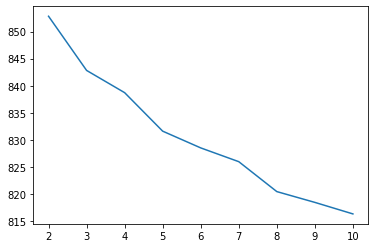

In [63]:
sns.lineplot(x=k_list,y=iner)
plt.show()

In [50]:
%%time
iner = []
k_list = list(range(2,11))
for i in range(2,11):
    k_model = Jaccard_K_Means(enron_sample_mat, num_c=i, n_init=10, max_iter=300, tol=10**-2, thres=0.1)
    iner.append(k_model.inertia)

Wall time: 1h 23min 53s


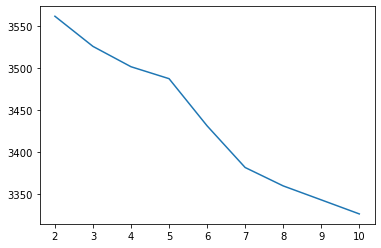

In [51]:
sns.lineplot(x=k_list,y=iner)
plt.show()